In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from include.Connection import Connection
from include.Tools import *
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
# filePath = './connection.test.log'
logDate = "2020-05-13"
filePath = "./logs/connection.{0}.log".format(logDate)
df = pd.DataFrame()
start_time = dt.datetime.now()

with open(file = filePath, mode = "r", buffering = 1_000_000) as f:
    for line in f:
        keys, values = Connection.parse(line)
        df = df.append(pd.DataFrame(data=[values], columns=keys), ignore_index=True)

# --- Set DataFrame.index to the unique "ID" field:
df.set_index("ID", inplace=True)
# --- Replace noname user name with "NaN" value:
df["User"].mask(df["User"] == "", "NaN", inplace=True)

# --- Replace empty DestinationHostName with their DestinationIp.
# in some cases it looks like Kerio bug, 
# where, for a bunch of lines with the same Destination IP
# there is just missing Destination HostName.
# Possibly more sophisticated replacement is required here...
df["DestinationHost"].mask(
    df["DestinationHost"] == "", 
    df["DestinationIp"], inplace=True)

# --- finally, count the processing time and show it as formatted string:
duration = (dt.datetime.now()-start_time).total_seconds()
print("Data has been processed in: {0} hrs, {1} mins, {2} secs".format(
    # divmod(400, 86400)[0], # days
    int(divmod(duration, 3600)[0]),   # hrs
    int(divmod(duration, 60)[0]),     # mins
    int(duration % 60)                # secs
))

Data has been processed in: 0 hrs, 3 mins, 53 secs


In [3]:
# --- check what we've just got:
df.head(3)

,DATETIME,Rule,Service,User,Protocol,SourceHost,SourceIp,SourcePort,DestinationHost,DestinationIp,DestinationPort,Duration,Bytes.Transmitted,Bytes.Accepted,Bytes.Total,Packets.Transmitted,Packets.Accepted,Packets.Total
ID,,,,,,,,,,,,,,,,,,
3874961,2020-05-13 00:00:03,HTTP Traffic (Parents),HTTPS,Vicky,TCP,,192.168.1.85,44833,www.udemy.com,104.16.91.52,443,24,6775,244986,251761,27,183,210
3873462,2020-05-13 00:00:04,HTTP Traffic (Parents),HTTPS,Pavel,TCP,OptiPlex-390,192.168.1.90,54209,ec2-52-27-123-15.us-west-2.compute.amazonaws.com,52.27.123.15,443,1152,5860,8950,14810,77,42,119
3874972,2020-05-13 00:00:08,HTTP Traffic (Parents),HTTPS,Vicky,TCP,,192.168.1.85,44840,www.udemy.com,104.16.91.52,443,20,617,144,761,2,3,5


In [4]:
# --- All the available users from the log:
users = list(df.groupby("User").groups)

# --- check what we've just got:
users

['Home', 'NaN', 'Pavel', 'Veronika', 'Vicky']

In [7]:
# --- OPTIONAL transformation of "users" list:

# NaN --> are unregistered users
users.remove("NaN")

# Home --> my home deivces, e.g.: TV, Alexa, etc.
users.remove("Home")

# --- Or, other possible ways to do the same:
# users = [user for user in users if user != "NaN"]
# users = ["user1", "User2", "User3"]

# --- check what we've just got:
users

['Pavel', 'Veronika', 'Vicky']

In [ ]:
# --- check particular user's taffic data:
# df.loc[df["User"] == "User1"].head(5)

In [8]:
# collect summary data for Pie Chart:
traffic_totals = []

# --- traffic summary for a custom list of users only:
for user in users:
    traffic_totals.append(df.loc[df["User"] == user]\
        .groupby(["User"])\
        .agg(np.sum)["Bytes.Total"].values[0])

traffic_summary = pd.DataFrame({
    "User": users, 
    "Traffic.MB": list(map(
        lambda size: BiteSize.transform(int(size), "MB"), traffic_totals
    ))
})

# --- check what we've got:
traffic_summary

,User,Traffic.MB
0,Pavel,1409.34
1,Veronika,1782.81
2,Vicky,1476.43


# Summary report:

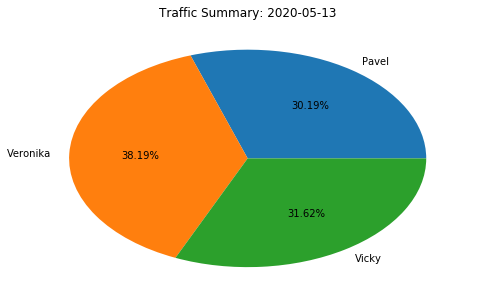

In [9]:
# --- Build a Pie Chart out of summary data:
plt.figure(figsize=(8,5))
plt.pie(x=traffic_summary["Traffic.MB"], labels=traffic_summary["User"], autopct="%.2f%%")
plt.title("Traffic Summary: {0}".format(logDate))
plt.show()

# TOP 10 web-sites statistics:

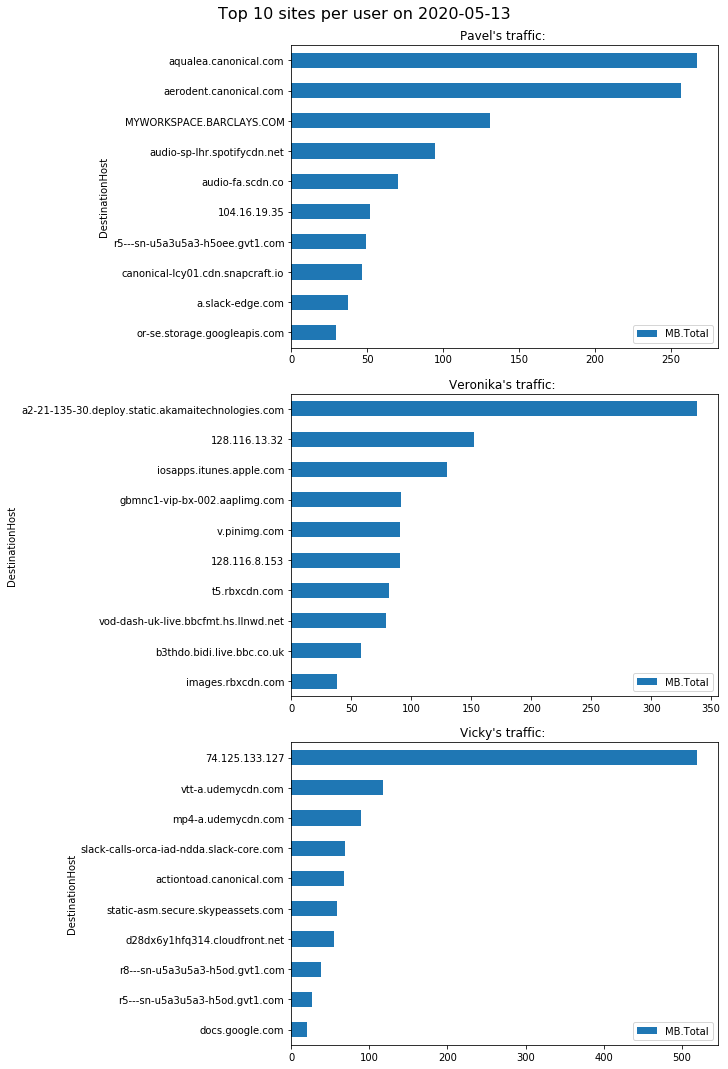

In [10]:
# --- if necessary apply additional transformation to "users" list.
# --- then:
# --- create subplots to place all graphs at the same figure:
fig, ax = plt.subplots(nrows=len(users), ncols=1, constrained_layout=True, sharex=False, sharey=False)
fig.set_size_inches(10, 15)
fig.suptitle("Top 10 sites per user on {0}\n".format(logDate), fontsize=16)

# --- iterate through uach reporting user and build their statistics:
size_unit = "MB"
for index, user in enumerate(users):    
    user_traffic_per_host  = pd.DataFrame({
        
        "DestinationHost": list(df.loc[df["User"] == user]\
            .groupby(["DestinationHost"]).groups),

        "{0}.Total".format(size_unit) : list(map(
            lambda size: BiteSize.transform(int(size), size_unit),
            list(df.loc[df["User"] == user]\
                .groupby(["DestinationHost"])\
                .agg(np.sum)["Bytes.Total"])
        ))
    })

    user_traffic_per_host\
        .sort_values(by="{0}.Total".format(size_unit), ascending=True)\
        .tail(10).set_index("DestinationHost")\
        .plot(kind="barh", ax=ax[index])
    
    ax[index].title.set_text("{0}'s traffic: ".format(user))
    # ax[index].get_yaxis().set_label_position("right")

plt.show()

## Query some particular user's details if necessary:

In [11]:
# Set user name:
user_name = "Veronika"

In [12]:
# User traffic by User Name: 
user_traffic = df.query(
        '`User` == "' + user_name + '" \
        ')[[
# --- columns ----------------------------------------------------------------------
        "User", "DATETIME", 
        "SourceHost", "SourceIp",
        "DestinationHost", "DestinationIp", 
        "DestinationPort", "Protocol",
        "Bytes.Total"]]

# --- Additional filters that we can use in df.query():
# and `DestinationHost`.str.contains("apple.com") \
# and `DATETIME` > "2020-05-29 11:00:00" and `DATETIME` < "2020-05-29 15:30:00" \

In [ ]:
# --- Alternatively: User's traffic by Source Host Name:
user_traffic = df.query('`SourceHost`.str.contains("-320")')[[
# --- columns ----------------------------------------------------------------------
        "User", "DATETIME", 
        "SourceHost", "SourceIp",
        "DestinationHost", "DestinationIp", 
        "DestinationPort", "Protocol",
        "Bytes.Total"]]
user_traffic

In [13]:
user_traffic.head()

,User,DATETIME,SourceHost,SourceIp,DestinationHost,DestinationIp,DestinationPort,Protocol,Bytes.Total
ID,,,,,,,,,
3874707,Veronika,2020-05-13 00:00:10,,192.168.1.76,images-na.ssl-images-amazon.com,151.101.17.16,443,TCP,1189
3874723,Veronika,2020-05-13 00:00:17,,192.168.1.76,images-na.ssl-images-amazon.com,151.101.17.16,443,TCP,1249
3874760,Veronika,2020-05-13 00:00:57,,192.168.1.76,images-na.ssl-images-amazon.com,151.101.17.16,443,TCP,3546
3874894,Veronika,2020-05-13 00:01:01,,192.168.1.76,images-na.ssl-images-amazon.com,151.101.17.16,443,TCP,20791
3875184,Veronika,2020-05-13 00:03:30,,192.168.1.76,images-na.ssl-images-amazon.com,151.101.17.16,443,TCP,4361


In [14]:
# Total Sum whole logged traffic in human-friendly format:
BiteSize.transform(int(user_traffic.groupby(["User"]).agg(np.sum)["Bytes.Total"].values[0]))

'1.74 GB'

### More custom filtering conditions:

In [15]:
# --- get unique DestinationIp arrdesses:
# user_traffic.query('`DestinationHost`.str.contains("akamai")').DestinationIp.unique()
#
# --- get list of internal IP adresses associated with the user:
# list(user_traffic.groupby(["SourceIp", "SourceHost"]).groups)
#
# --- min time when traffic has started:
print(user_traffic.query('`DestinationHost`.str.contains("apple.com")').groupby(["User"]).agg(np.min)["DATETIME"])
# e.g. 8:11 am
# --- max time when traffic has stopped:
print(user_traffic.query('`DestinationHost`.str.contains("apple.com")').groupby(["User"]).agg(np.max)["DATETIME"])
# e.g. 9:29 am

User
Veronika   2020-05-13 00:05:47
Name: DATETIME, dtype: datetime64[ns]
User
Veronika   2020-05-13 18:48:02
Name: DATETIME, dtype: datetime64[ns]


### Draw Top-10 bar:

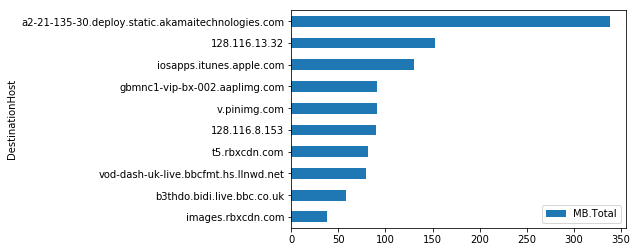

In [16]:
size_unit = "MB"
user_traffic_per_host  = pd.DataFrame({
    "DestinationHost": list(user_traffic\
        .groupby(["DestinationHost"]).groups),

    "{0}.Total".format(size_unit) : list(map(
        lambda size: BiteSize.transform(int(size), size_unit),
        list(user_traffic\
            .groupby(["DestinationHost"])\
            .agg(np.sum)["Bytes.Total"])
    ))
})

user_traffic_per_host\
    .sort_values(by="{0}.Total".format(size_unit), ascending=True)\
    .tail(10).set_index("DestinationHost")\
    .plot(kind="barh")
    
plt.show()

## More deep analysis:

In [17]:
# unique DestinationIp adresses:
pd.DataFrame(user_traffic.DestinationIp.unique()).head(5)

,0
0,151.101.17.16
1,108.177.15.108
2,64.233.167.108
3,108.177.15.109
4,17.253.108.125


## User-traffic by Hour as BarChar:

In [18]:
user_traffic.reset_index(level=0, inplace=True)
user_traffic.set_index("DATETIME", inplace=True)
user_traffic.head()

,ID,User,SourceHost,SourceIp,DestinationHost,DestinationIp,DestinationPort,Protocol,Bytes.Total
DATETIME,,,,,,,,,
2020-05-13 00:00:10,3874707,Veronika,,192.168.1.76,images-na.ssl-images-amazon.com,151.101.17.16,443,TCP,1189
2020-05-13 00:00:17,3874723,Veronika,,192.168.1.76,images-na.ssl-images-amazon.com,151.101.17.16,443,TCP,1249
2020-05-13 00:00:57,3874760,Veronika,,192.168.1.76,images-na.ssl-images-amazon.com,151.101.17.16,443,TCP,3546
2020-05-13 00:01:01,3874894,Veronika,,192.168.1.76,images-na.ssl-images-amazon.com,151.101.17.16,443,TCP,20791
2020-05-13 00:03:30,3875184,Veronika,,192.168.1.76,images-na.ssl-images-amazon.com,151.101.17.16,443,TCP,4361


In [19]:
user_traffic_byhour = user_traffic.groupby([user_traffic.index.hour.rename('Hour')])['Bytes.Total'].sum().reset_index().set_index("Hour")
user_traffic_byhour

,Bytes.Total
Hour,
0,1682697
1,639087
2,698809
3,590200
4,192398506
5,1000991
6,926419
7,1002764
8,13919711


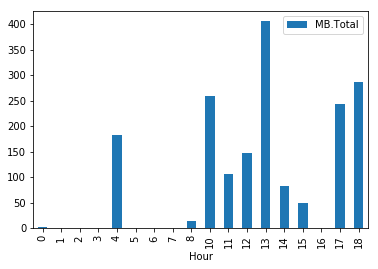

In [20]:
size_unit = "MB"
pd.DataFrame({
    "{0}.Total".format(size_unit) : list(map(
        lambda size: BiteSize.transform(int(size), size_unit),
        list(user_traffic_byhour["Bytes.Total"])
    ))
}, index = user_traffic_byhour.index)\
 .plot(kind="bar")

# plt.title(user_name)
plt.show()

### Closer look at some shorter period of time:

In [ ]:
# --- hours between 8:00 and 16:00
user_traffic_byhour.iloc[8:16]

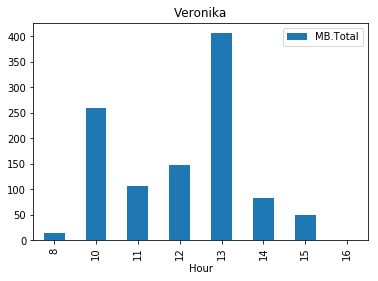

In [21]:
size_unit = "MB"
pd.DataFrame({
    "{0}.Total".format(size_unit) : list(map(
        lambda size: BiteSize.transform(int(size), size_unit),
        list(user_traffic_byhour.iloc[8:16]["Bytes.Total"])
    ))
}, index=user_traffic_byhour[8:16].index) \
  .plot(kind="bar")

plt.title(user_name)
plt.show()